# Chapter 5

In [1]:
import os
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
np.random.seed(0)

In [3]:
# Load data
data = pd.read_csv(os.path.join("Data", "WaffleDivorce.csv"), delimiter=";")

In [4]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [5]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

def unstandardize(std_series, original_series):
    """Given an input series restandardize"""
    unstandardize = std_series*original_series.std() + original_series.mean()
    return unstandardize

#### Code 5.1

In [6]:
# Standard regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_sd"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

#### Code 5.2

In [7]:
data["MedianAgeMarriage"].std()

1.2436303013880823

#### Code 5.3

In [8]:
with pm.Model() as divorce_model_age:
    a = pm.Normal("a", 0, .2)
    bA = pm.Normal("bA", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bA*data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_divorce_age = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5309.69draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0924b8a10>,
      dtype=object)

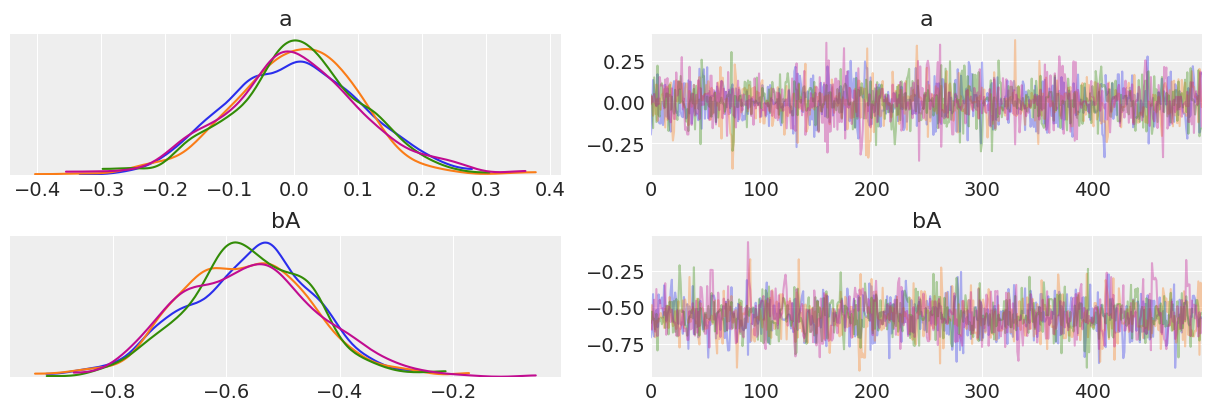

In [9]:
az.plot_trace(trace_divorce_age, var_names = ["a", "bA"])

#### Code 5.4

Text(0.5, 0.98, ' Figure 5.3')

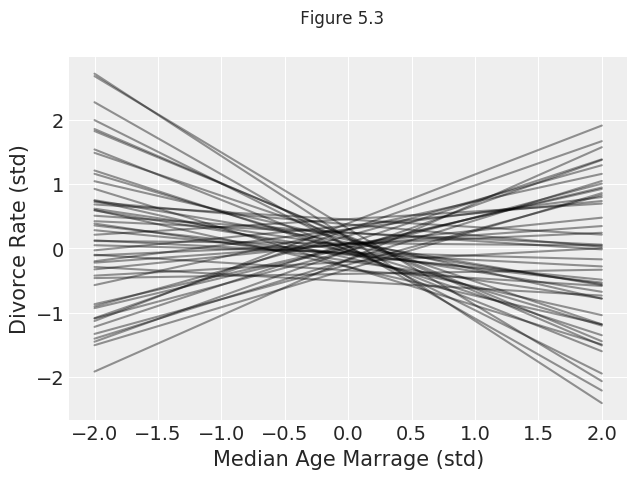

In [10]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, ba in zip(prior_samples["a"][:50], prior_samples["bA"][:50]):
    y = a + ba*x 
    ax.plot(x, y, c="black", alpha=.4)
    
ax.set_xlabel("Median Age Marrage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle(" Figure 5.3")

#### Code 5.5

In [11]:
trace_divorce_age["bA"].shape

(2000,)

In [12]:
age_std_seq = np.linspace(-3, 3.2, 30)

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
trace_divorce_age_thinned = trace_divorce_age[::10]
mu_pred = np.zeros((len(age_std_seq), len(trace_divorce_age_thinned) * trace_divorce_age_thinned.nchains))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = trace_divorce_age_thinned["a"] + trace_divorce_age_thinned["bA"]*age_std

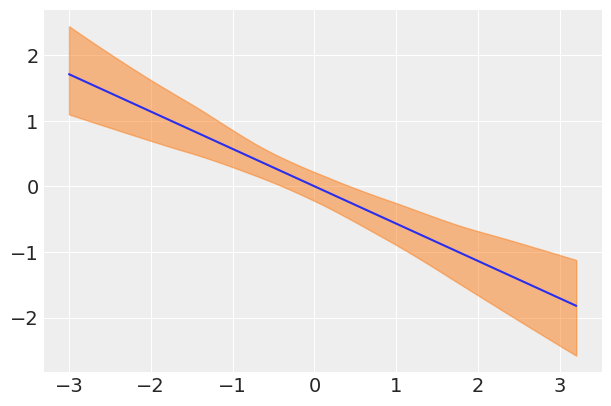

In [23]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred.mean(axis=1)
plt.plot(age_std_seq, mu_mean)
az.plot_hpd(age_std_seq, mu_pred.T)

## Extra code
Code that recreates some of the figures whos code isnt included in the book

#### Figure 5.1

In [15]:
# Change domain of vars back to domain of original units
regular_age_seq = unstandardize(age_std_seq, data["MedianAgeMarriage"])
regular_divorce_seq = unstandardize(mu_mean, data["Divorce"])
regular_divorce_seq_pred = unstandardize(mu_pred, data["Divorce"])

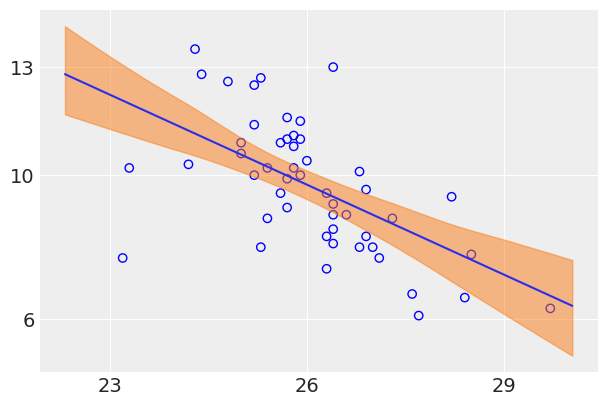

In [22]:
fig, ax = plt.subplots()

ax.scatter(data["MedianAgeMarriage"], data["Divorce"], facecolors='none', edgecolors='b')
ax.set_yticks([13, 10, 6])
ax.set_xticks([23, 26, 29])
ax.plot(regular_age_seq, regular_divorce_seq)
az.plot_hpd(regular_age_seq, regular_divorce_seq_pred.T)